In [8]:
import numpy as np
import matplotlib.pyplot as plt

import numpy as np

def create_parameter_table_unsteady(left_bounds,right_bounds, init_bounds, L_bounds, num_points):
    left_Tb = np.linspace(left_bounds[0], left_bounds[1], num_points)
    right_Tb = np.linspace(right_bounds[0], right_bounds[1], num_points)
    init_Tb = np.linspace(init_bounds[0], init_bounds[1], num_points)
    L_b = np.linspace(L_bounds[0], L_bounds[1], num_points)

    
    #print('create_parameter_table_steady-------')
    #print(left_Tb)
    #print(right_Tb)
    #print(init_Tb)
    #print(L_b)

    # Create a meshgrid from the parameter values
    param1_grid, param2_grid, param3_grid, param4_grid = np.meshgrid(left_Tb, right_Tb, init_Tb,L_b, indexing='ij')

    # Reshape the grids to a table
    param_table = np.vstack([param1_grid.ravel(), param2_grid.ravel(), param3_grid.ravel(), param4_grid.ravel()]).T

    return param_table

# Example usage:
#param1_bounds = (0, 1)
#param2_bounds = (10, 20)
#param3_bounds = (-5, 5)
#num_points = 3

#parameter_table = create_parameter_table(param1_bounds, param2_bounds, param3_bounds, num_points)
#print(parameter_table)

Nx = 50        # Number of spatial grid points
k = 1.0        #Alpha
Nt = 500      #Timesteps
t_max = 5.0   #Time range


    #print(parameter_table.shape)


def simuluate_unsteady_fdm(T_left,T_right,T_init, L):
    # Discretize the spatial domain
    dx = L / Nx
    x = np.linspace(0, L, Nx + 1)
    alpha = 0.01  # Thermal diffusivity
    # Initialize the temperature field
    T = np.full((Nx + 1,), T_init, dtype=np.float64) #np.zeros(Nx + 1)
    T[0] = T_left
    T[Nx] = T_right
    
    # Define the heat source or sink term (q(x)) (in watts per meter)
    q = np.zeros(Nx + 1)
    #q[Nx] = q_right
    
    
    dt = t_max / Nt  # Time step size (in seconds)
    
    # Create an array to store temperature at each time step
    T_history = []
    
    T_prev = np.copy(T)
    
    # Transient Solver
    for n in range(Nt):
        T_new = np.copy(T)
        for i in range(1, Nx):
            #T_new[i] = T_prev[i] + (k * dt / dx**2) * (T[i - 1] - 2 * T[i] + T[i + 1]) + (q[i] * dt / k)
            T_new[i] = T[i] + alpha * (T[i - 1] - 2 * T[i] + T[i + 1]) / (dx**2) * dt
        T = np.copy(T_new)
        T_prev = np.copy(T_new)
        T_history.append(T.copy())
    
    T_history_fdm = np.array(T_history)
    #print(T.shape)
    return T_history_fdm

def simuluate_unsteady_fdm_Tm(T_left,T_right,T_init, L, Tm):
    # Discretize the spatial domain
    dx = L / Nx
    x = np.linspace(0, L, Nx + 1)
    alpha = 0.01  # Thermal diffusivity
    # Initialize the temperature field
    T = np.full((Nx + 1,), T_init, dtype=np.float64) #np.zeros(Nx + 1)
    T[0] = T_left
    T[Nx] = T_right
    
    # Define the heat source or sink term (q(x)) (in watts per meter)
    q = np.zeros(Nx + 1)
    #q[Nx] = q_right
    
    
    dt = t_max / Nt  # Time step size (in seconds)
    
    # Create an array to store temperature at each time step
    T_history = []
    
    T_prev = np.copy(T)

    n = 0
    # Transient Solver
    Titer = 0
    while True:
        T_new = np.copy(T)
        for i in range(1, Nx):
            #T_new[i] = T_prev[i] + (k * dt / dx**2) * (T[i - 1] - 2 * T[i] + T[i + 1]) + (q[i] * dt / k)
            T_new[i] = T[i] + alpha * (T[i - 1] - 2 * T[i] + T[i + 1]) / (dx**2) * dt
        
        T = np.copy(T_new)

        if (Tm < n*dt):
            
            if (Titer>=Nt):
                break
    
            T_history.append(T.copy())
            Titer = Titer + 1

            

        n = n+1
            
    
    T_history_fdm = np.array(T_history)
    #print(T.shape)
    return T_history_fdm

def generate_parameter_and_measurement_tables(parameter_table, simulate_function=simuluate_unsteady_fdm):
    num_measurements = Nx + 1
    num_params = parameter_table.shape[1]
    #print(parameter_table)

    # Create a table for measurements with an additional ID column
    measurement_table = np.zeros((parameter_table.shape[0], Nt, num_measurements))
    parameter_table_new = np.zeros((parameter_table.shape[0], parameter_table.shape[1]))
    grid_table = np.zeros((parameter_table.shape[0], num_measurements))
    #measurement_table[:, 0] = np.arange(1, parameter_table.shape[0] + 1)  # Assign unique IDs
    #parameter_table_new[:, 0] = np.arange(1, parameter_table.shape[0] + 1)  # Assign unique IDs
    #grid_table[:, 0] = np.arange(1, parameter_table.shape[0])  # Assign unique IDs
    #transient_measurements_simulated = np.vstack([simulate_transient(param_values) for param_values in parameter_table])

    # Copy parameter values to the first `num_params` columns
    #measurement_table[:, 1:num_params + 1] = parameter_table
    start = 0

    # Apply the simulate function to generate 100 measurements for each row
    for i in range(parameter_table.shape[0]):
        param_values = parameter_table[i, :]
        T_left,T_right,T_init, L = param_values
        measurements = simulate_function(T_left,T_right,T_init, L)
        #print("------------")
        #print(measurement_table.shape)
        #print(measurements.shape)
        #print(measurement_table[i, 1:].shape)
        #measurement_table[i, 1:] = measurements
        measurement_table[i, :,:] = measurements
        grid_table[i, :] = np.linspace(0, L, num_measurements)
        #parameter_table_new[i, 1:] = param_values

    return parameter_table, np.array(measurement_table), grid_table
    
def generate_unsteady_state_1D_cond(left_up,left_down,right_up,right_down, init_up,init_down, L_up, L_down, num_points):
    left_bounds = (left_down, left_up)
    right_bounds = (right_down, right_up)
    init_bounds = (init_down, init_up)
    L_bounds = (L_down, L_up)
    parameter_table = create_parameter_table_unsteady(left_bounds,right_bounds, init_bounds, L_bounds, num_points)
    #print(parameter_table.shape)
    parameter_table_new,measurement_table,grid_table = generate_parameter_and_measurement_tables(parameter_table)
    return parameter_table_new,measurement_table, grid_table 


import numpy as np
import matplotlib.pyplot as plt

def plot_random_measurements(parameter_table, measurement_table, num_random_measurements=5):
    # Get IDs and random indices for the measurements
    ids = range(measurement_table.shape[0]-1)
    random_indices = np.random.choice(ids, num_random_measurements, replace=False)

    # Plot random measurements with IDs in the legend
    for i in random_indices:
        row_index = np.where(ids == i)[0][0]
        measurements = measurement_table[row_index]
        parameters = parameter_table[row_index]
        T_left,T_right,T_init, L = parameters
        plt.clf()
        plt.imshow(measurements, cmap='hot', extent=[0, L, 0, t_max], aspect='auto', origin='lower')
        plt.colorbar(label='Temperature (°C)')
        plt.xlabel('Position (x) (in meters)')
        plt.ylabel('Time (t) (in seconds)')
        plt.title('Transient Temperature Distribution (1D Heat Conduction)')
        plt.show()

    #plt.xlabel('Measurement Index')
    #plt.ylabel('Measurement Value')
    #plt.legend()
    #plt.title(f'Random {num_random_measurements} Measurements')
    #plt.show()

    



(16, 4)
(16, 500, 51)
(16, 51)


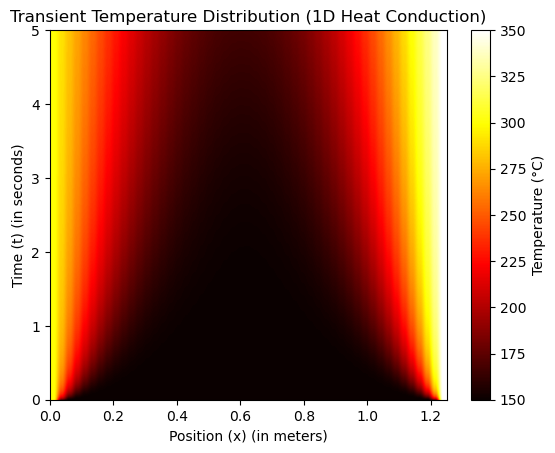

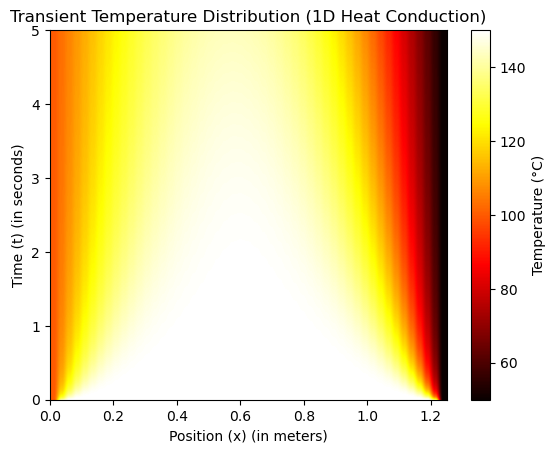

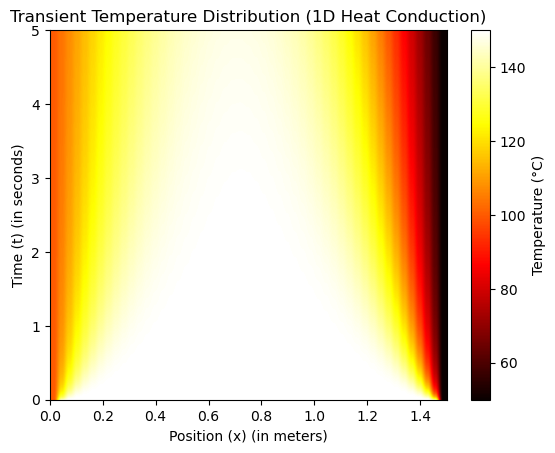

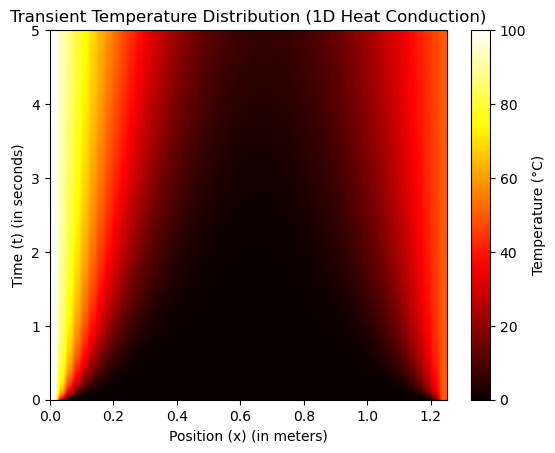

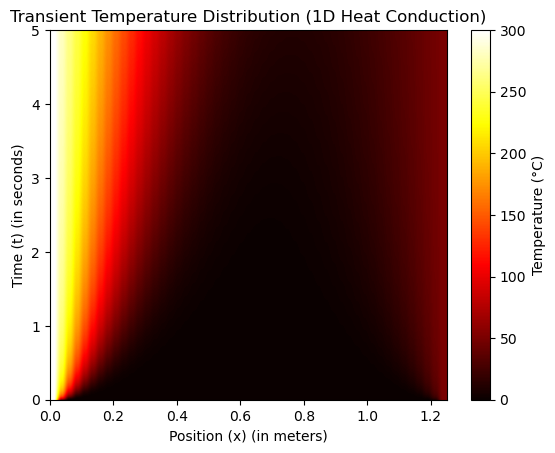

In [9]:
left_up = 300.
left_down = 100.
right_up = 350.
right_down = 50.
init_up = 150.
init_down = 0.
num_points = 2
L_up = 1.5
L_down = 1.25




parameter_table_new,measurement_table, grid_table = generate_unsteady_state_1D_cond(left_up,left_down,right_up,right_down, init_up,init_down,L_up, L_down,num_points)

print(parameter_table_new.shape)
#print(parameter_table_new)
print(measurement_table.shape)
#print(measurement_table)
print(grid_table.shape)

num_random_measurements = 5

# Plot random measurements and print corresponding parameters from the default simulation
plot_random_measurements(parameter_table_new, measurement_table, num_random_measurements)

In [10]:
from pydmd import ParametricDMD, DMD, HankelDMD
from ezyrb import POD, RBF

dmd = DMD(svd_rank=-1)
rom = POD(rank=20)
interpolator = RBF()

pdmd_monolithic = ParametricDMD(dmd, rom, interpolator)

pdmd_monolithic.fit(
    np.transpose(measurement_table, axes=(0, 2, 1)), parameter_table_new
) 


/data/anaconda3/envs/load_curve/lib/python3.11/site-packages/pydmd/snapshots.py:72: UserWarning: Input data condition number 2.1917502505881295e+18. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


(5, 500, 51)
[[151.58231223 125.76913858  81.27163997   1.3193929 ]
 [278.65990193 245.5741232  136.89881763   1.39459723]
 [266.77907574 309.70567071  88.24154092   1.45283308]
 [133.41150192  69.52018802   6.0901773    1.3942742 ]
 [265.57129965 270.27596087  26.09045751   1.36042451]]
(5, 500, 51)


<Figure size 640x480 with 0 Axes>

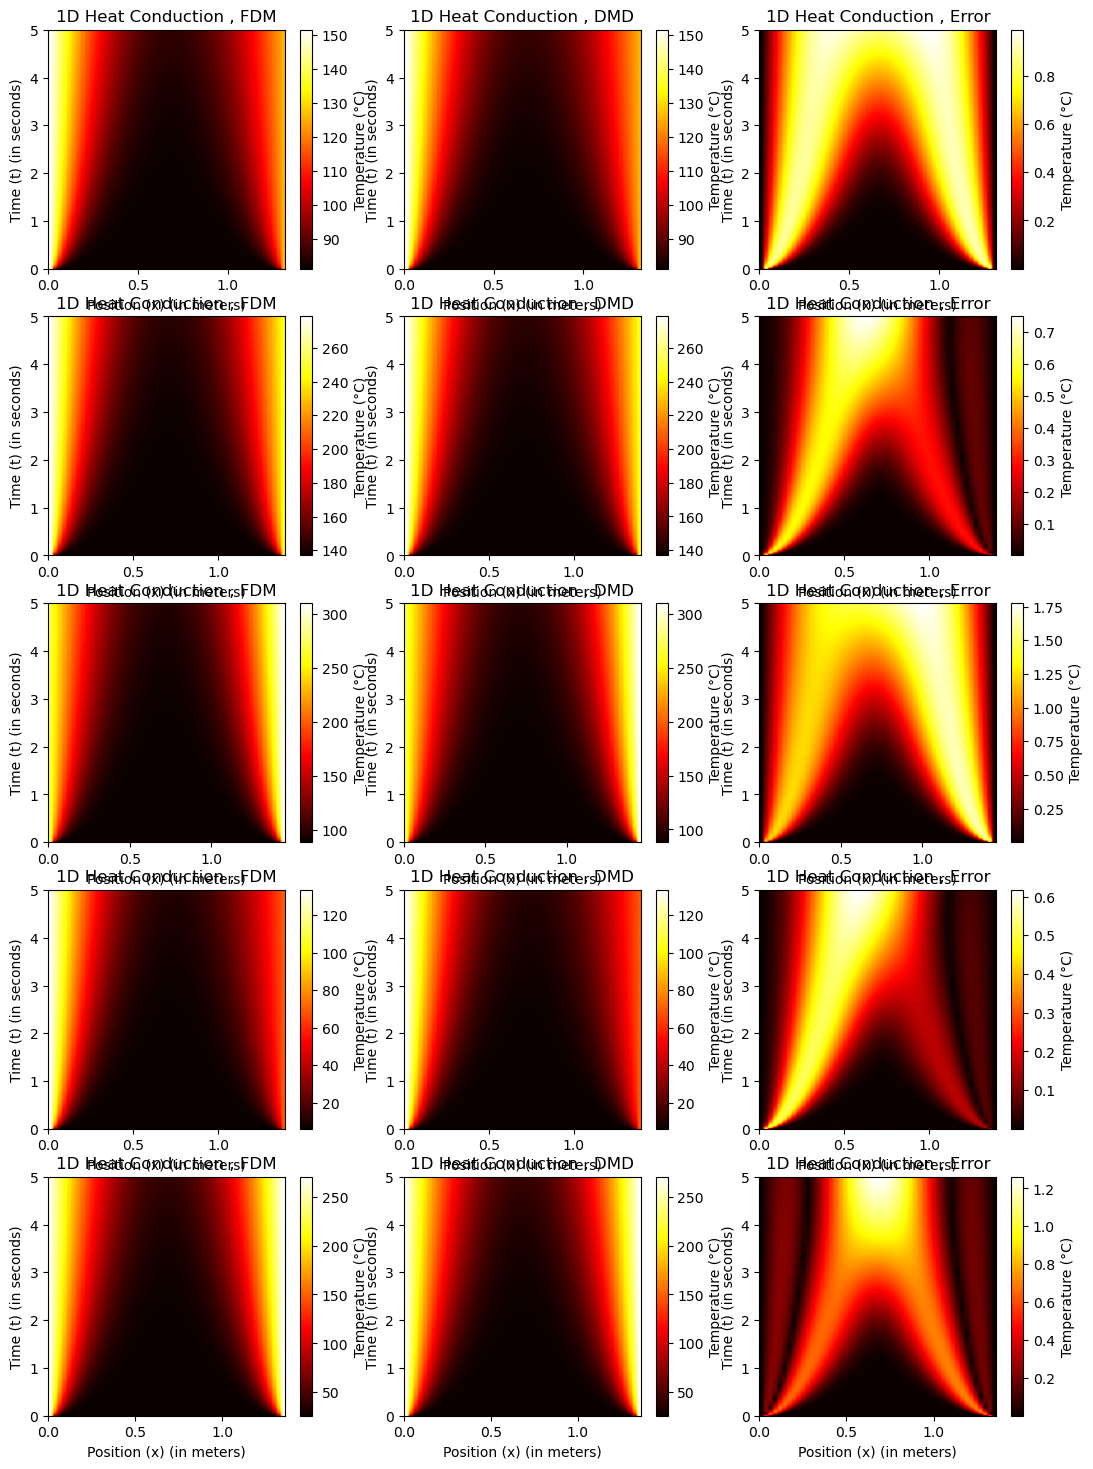

In [11]:
def generate_random_parameters(left_bounds,right_bounds, init_bounds, L_bounds, num_samples):
    param_bounds = [left_bounds,right_bounds, init_bounds, L_bounds]
    param_values = [np.random.uniform(bounds[0], bounds[1], num_samples) for bounds in param_bounds]
    param_samples = np.vstack(param_values).T
    return param_samples

def generate_measurements_nn(model, param_samples, scaler_X, scaler_y):
    param_samples_scaled = scaler_X.transform(param_samples)
    measurements_scaled = model.predict(param_samples_scaled)
    measurements = scaler_y.inverse_transform(measurements_scaled)
    return measurements

left_bounds = (left_down, left_up)
right_bounds = (right_down, right_up)
init_bounds = (init_down, init_up)
L_bounds = (L_down, L_up)

Tm_down = 1.0
Tm_up = 5.0
Tm_bounds = (Tm_down, Tm_up)

num_samples = 5
random_parameters = generate_random_parameters(left_bounds,right_bounds, init_bounds, L_bounds, num_samples)
#print(random_parameters)

measurements_simulated = np.array([simuluate_unsteady_fdm(left,right,init,L) for left,right,init,L in random_parameters])
print(measurements_simulated.shape)
print(random_parameters)
#print(dt)
#measurements_simulated = np.where(measurements_simulated[:, -1] == random_parameters[-1])[0]

pdmd_monolithic.parameters = random_parameters
# Generate measurements using the trained neural network
measurements_dmd = pdmd_monolithic.reconstructed_data
measurements_dmd = np.transpose(measurements_dmd.real, axes=(0, 2, 1))
print(measurements_dmd.shape)
#print(dtype(measurements_dmd))
#print("Random Parameter Samples:")
#print(random_parameters)
#measurements_nn
plt.clf()
plt.figure(figsize=(13, 18))
r= num_samples
c = 3
ind = 1
for i in range(num_samples):
    plt.subplot(r, c, ind)
    T_left,T_right,T_init, L = random_parameters[i]
    plt.imshow(measurements_simulated[i], cmap='hot', extent=[0, L, 0, t_max], aspect='auto', origin='lower')
    plt.colorbar(label='Temperature (°C)')
    plt.xlabel('Position (x) (in meters)')
    plt.ylabel('Time (t) (in seconds)')
    plt.title('1D Heat Conduction , FDM')

    ind = ind + 1
    plt.subplot(r, c, ind)
    plt.imshow(measurements_dmd[i], cmap='hot', extent=[0, L, 0, t_max], aspect='auto', origin='lower')
    plt.colorbar(label='Temperature (°C)')
    plt.xlabel('Position (x) (in meters)')
    plt.ylabel('Time (t) (in seconds)')
    plt.title('1D Heat Conduction , DMD')
    
    ind = ind + 1

    error = np.abs(measurements_dmd - measurements_simulated)
    plt.subplot(r, c, ind)
    plt.imshow(error[i]  , cmap='hot', extent=[0, L, 0, t_max], aspect='auto', origin='lower')
    plt.colorbar(label='Temperature (°C)')
    plt.xlabel('Position (x) (in meters)')
    plt.ylabel('Time (t) (in seconds)')
    plt.title('1D Heat Conduction , Error')

    ind = ind + 1
    

(5, 500, 51)
[[183.33120527 131.7695565   75.18345581   1.26320755]
 [289.54960913 324.74619426 136.93441595   1.43523124]
 [288.22169777 310.46388482 139.35881662   1.44349599]
 [139.81096459 330.93478142  57.60741462   1.32743378]
 [188.12846481 213.90444277  37.26441967   1.28468564]]
(5, 500, 51)


<Figure size 640x480 with 0 Axes>

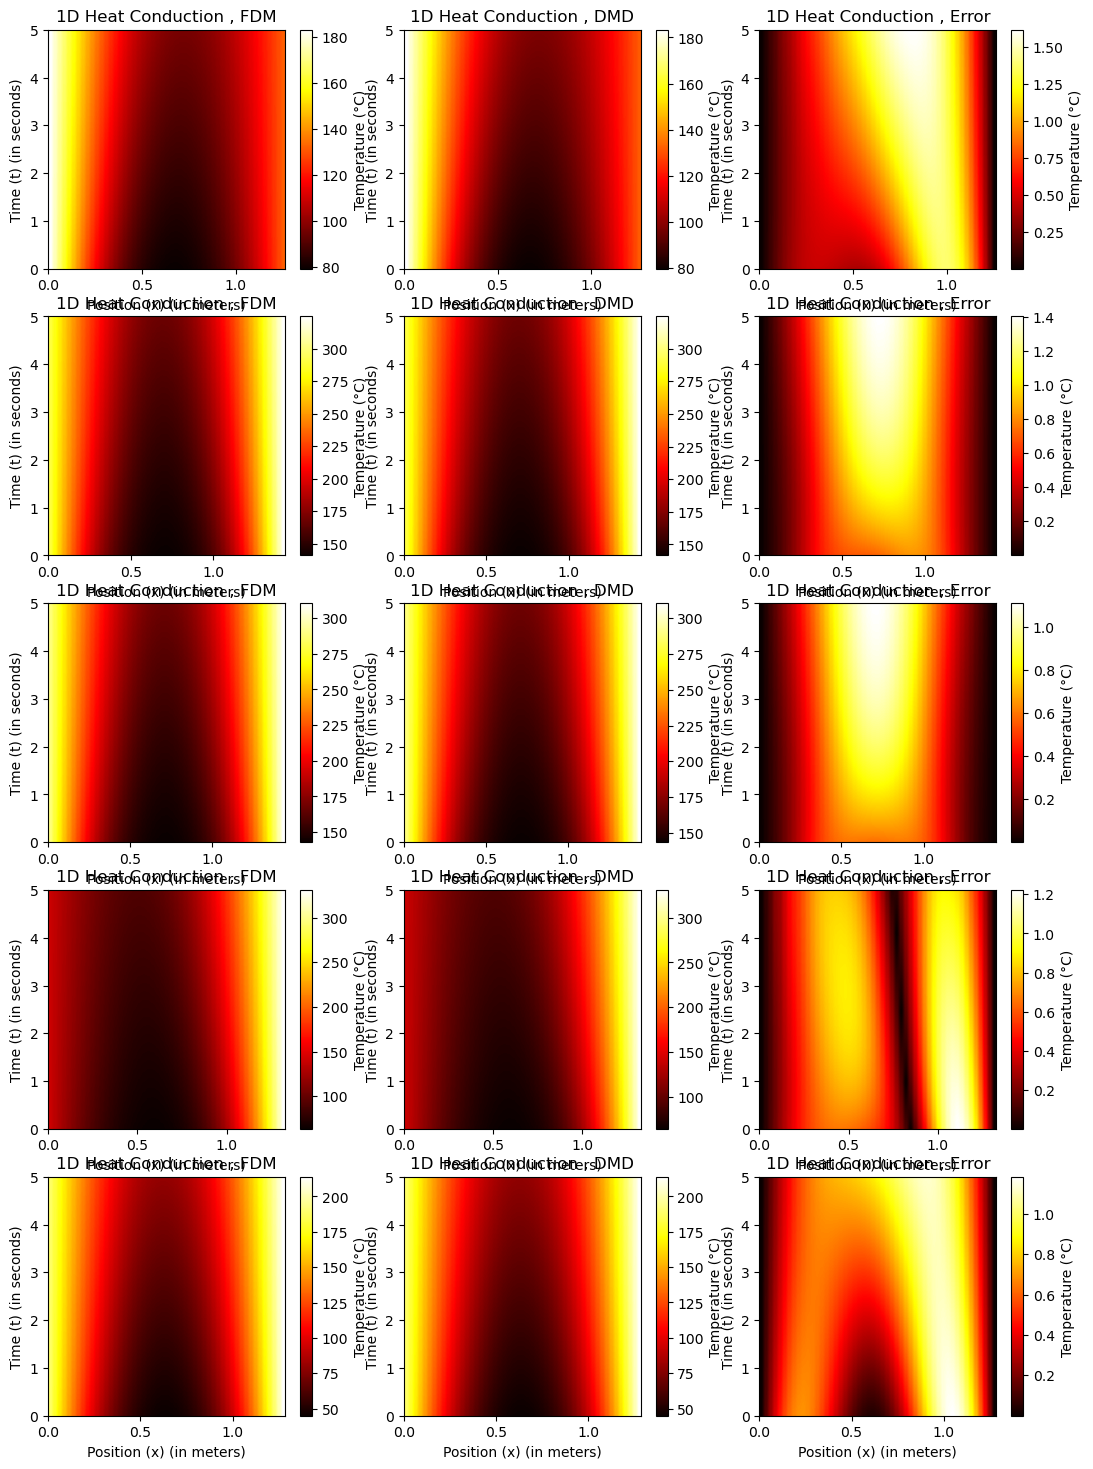

In [12]:
#Extrapolation
Tm = 4.0

num_samples = 5
N_nonpredict = 100

pdmd_monolithic.dmd_time["t0"] = (
    pdmd_monolithic.original_time["tend"] - N_nonpredict + 1
)
pdmd_monolithic.dmd_time["tend"] = (
    pdmd_monolithic.original_time["tend"] + 4*N_nonpredict
)

random_parameters = generate_random_parameters(left_bounds,right_bounds, init_bounds, L_bounds, num_samples)
#print(random_parameters)

measurements_simulated = np.array([simuluate_unsteady_fdm_Tm(left,right,init,L,Tm) for left,right,init,L in random_parameters])

print(measurements_simulated.shape)
print(random_parameters)
#print(dt)
#measurements_simulated = np.where(measurements_simulated[:, -1] == random_parameters[-1])[0]

pdmd_monolithic.parameters = random_parameters
# Generate measurements using the trained neural network
measurements_dmd = pdmd_monolithic.reconstructed_data
measurements_dmd = np.transpose(measurements_dmd.real, axes=(0, 2, 1))
print(measurements_dmd.shape)
#print(dtype(measurements_dmd))
#print("Random Parameter Samples:")
#print(random_parameters)
#measurements_nn
plt.clf()
plt.figure(figsize=(13, 18))
r= num_samples
c = 3
ind = 1
#print(measurements_dmd[0])
for i in range(num_samples):
    plt.subplot(r, c, ind)
    T_left,T_right,T_init, L = random_parameters[i]
    plt.imshow(measurements_simulated[i], cmap='hot', extent=[0, L, 0, t_max], aspect='auto', origin='lower')
    plt.colorbar(label='Temperature (°C)')
    plt.xlabel('Position (x) (in meters)')
    plt.ylabel('Time (t) (in seconds)')
    plt.title('1D Heat Conduction , FDM')

    ind = ind + 1
    plt.subplot(r, c, ind)
    plt.imshow(measurements_dmd[i], cmap='hot', extent=[0, L, 0, t_max], aspect='auto', origin='lower')
    plt.colorbar(label='Temperature (°C)')
    plt.xlabel('Position (x) (in meters)')
    plt.ylabel('Time (t) (in seconds)')
    plt.title('1D Heat Conduction , DMD')
    
    ind = ind + 1

    error = np.abs(measurements_dmd - measurements_simulated)
    plt.subplot(r, c, ind)
    plt.imshow(error[i]  , cmap='hot', extent=[0, L, 0, t_max], aspect='auto', origin='lower')
    plt.colorbar(label='Temperature (°C)')
    plt.xlabel('Position (x) (in meters)')
    plt.ylabel('Time (t) (in seconds)')
    plt.title('1D Heat Conduction , Error')

    ind = ind + 1